# Dataloaders

In [1]:
import os
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

### One description per image

In [2]:
df = pd.read_csv('../captions.txt')
df[:6]

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting


In [3]:
df.drop_duplicates(subset=['image'], inplace=True)

In [4]:
df[:6]

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
10,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
15,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
20,1007129816_e794419615.jpg,A man in an orange hat starring at something .
25,1007320043_627395c3d8.jpg,A child playing on a rope net .


In [5]:
df.to_csv('../one_desc.txt', index=0)

In [6]:
df = pd.read_csv('one_desc.txt')

In [7]:
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


## Converting text to numerical values
1. Vocabulary mapping each word to an index
2. Pytorch dataset
3. padding sequnences to the same length

In [8]:
# loading spacy tokenizer
#!python -m spacy download en
spacy_en = spacy.load("en")

In [71]:
itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
class Vocabulary:
    def __init__(self, freq_threshold):

        self.freq_threshold = freq_threshold
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_en.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                    
                if frequencies[word] == self.freq_threshold:
                    stoi[word] = idx
                    itos[idx] = word
                    idx += 1
                    
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        
        return [
            stoi[token] if token in stoi else stoi["<UNK>"]
            for token in tokenized_text
        ]

In [72]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=2):
        self.root_dir = root_dir
        self.df = pd.read_csv(root_dir +'/'+ captions_file)
        self.transform = transform
        
        # get img and caption columns
        self.imgs = self.df['image']
        self.captions = self.df['caption']
        
        # initialize vacab and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir,"Images", img_id)).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        numericalized_caption = [stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [73]:
df = pd.read_csv('one_desc.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


In [74]:
ds = FlickrDataset('..', 'one_desc.txt')

In [75]:
for i in range(5):
    print(ds[i][0].size, ds[i][1].shape)

(375, 500) torch.Size([20])
(500, 375) torch.Size([11])
(500, 400) torch.Size([22])
(500, 410) torch.Size([15])
(500, 461) torch.Size([12])


'<SOS> a black dog leaps over a log . <EOS>'

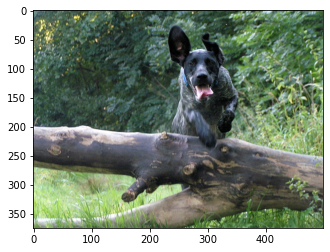

In [76]:
# check one sample
j = 9
plt.imshow(ds[j][0])
' '.join([itos[w.item()] for w in ds[j][1]])

In [77]:
# padding seqs
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        
        return imgs, targets

In [78]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [79]:
import multiprocessing
multiprocessing.cpu_count()

8

In [80]:
batch_size=128
num_workers=8
shuffle=True
pin_memory=True

In [81]:
dataset = FlickrDataset("..", "one_desc.txt", transform=transform)

pad_idx = stoi["<PAD>"]

train_loader = DataLoader(
    dataset = dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    pin_memory=pin_memory,
    collate_fn=MyCollate(pad_idx=pad_idx),
    drop_last=True
)

In [82]:
for idx, (imgs, captions) in enumerate(train_loader):
    print(imgs.shape)
    print(captions.shape)
    print('_'*20)
    if idx == 4: break

torch.Size([128, 3, 224, 224])
torch.Size([26, 128])
____________________
torch.Size([128, 3, 224, 224])
torch.Size([33, 128])
____________________
torch.Size([128, 3, 224, 224])
torch.Size([28, 128])
____________________
torch.Size([128, 3, 224, 224])
torch.Size([28, 128])
____________________
torch.Size([128, 3, 224, 224])
torch.Size([33, 128])
____________________


In [83]:
from fastai.vision.all import *

### The Model

In [84]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if itos[predicted.item()] == "<EOS>":
                    break

        return [itos[idx] for idx in result_caption]

In [85]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = False
train_CNN = False

In [86]:
step = 0

In [87]:
import torch
from tqdm import tqdm,trange
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [88]:
import torch
import torchvision.transforms as transforms
from PIL import Image


def print_examples(model, device, dataset):

    model.eval()
    test_img1 = transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(
        0
    )
    print("Example 1 CORRECT: Dog on a beach by the ocean")
    print(
        "Example 1 OUTPUT: "
        + " ".join(model.caption_image(test_img1.to(device)))
    )
    print('_'*60)
    test_img2 = transform(
        Image.open("test_examples/child.jpg").convert("RGB")
    ).unsqueeze(0)
    print("Example 2 CORRECT: Child holding red frisbee outdoors")
    print(
        "Example 2 OUTPUT: "
        + " ".join(model.caption_image(test_img2.to(device)))
    )
    print('_'*60)
    test_img3 = transform(Image.open("test_examples/bus.png").convert("RGB")).unsqueeze(
        0
    )
    print("Example 3 CORRECT: Bus driving by parked cars")
    print(
        "Example 3 OUTPUT: "
        + " ".join(model.caption_image(test_img3.to(device)))
    )
    print('_'*60)
    test_img4 = transform(
        Image.open("test_examples/boat.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 4 CORRECT: A small boat in the ocean")
    print(
        "Example 4 OUTPUT: "
        + " ".join(model.caption_image(test_img4.to(device)))
    )
    print('_'*60)
    test_img5 = transform(
        Image.open("test_examples/horse.png").convert("RGB")
    ).unsqueeze(0)
    print("Example 5 CORRECT: A cowboy riding a horse in the desert")
    print(
        "Example 5 OUTPUT: "
        + " ".join(model.caption_image(test_img5.to(device)))
    )
    model.train()

In [89]:
# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(itos)
num_layers = 2
learning_rate = 3e-4
num_epochs = 100

In [90]:
# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
# Only finetune the CNN
for name, param in model.encoderCNN.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

In [92]:
model.train()

for epoch in range(100):
    print(f"Epoch: {epoch}")
    # Uncomment the line below to see a couple of test cases
    print_examples(model, device, dataset)


    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )
        step += 1

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()

Epoch: 0
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: overlooks worn worn worn wagon wagon gray overlooks naked worn worn worn wagon herself gray overlooks overlooks worn worn worn wagon wagon herself gray overlooks worn worn worn wagon wagon herself gray overlooks overlooks worn worn worn wagon wagon herself gray overlooks worn worn worn wagon wagon herself gray overlooks
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: overlooks worn worn worn wagon wagon gray overlooks naked worn worn worn wagon herself gray overlooks overlooks worn worn worn wagon wagon herself gray overlooks worn worn worn wagon wagon herself gray overlooks overlooks worn worn worn wagon wagon herself gray overlooks worn worn worn wagon wagon herself gray overlooks
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: overlooks worn worn worn

Epoch: 1
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a a a a a a a a a a . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a a a a a a a a a a . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a a a a a a a a a a . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a a a a a a a a a a . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a a a a a a a a a a . <EOS>


Epoch: 2
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a a a a a a a a . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a a a a a a a a . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a a a a a a a a . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a a a a a a a a . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a a a a a a a a . <EOS>


Epoch: 3
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a a a a a a . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a a a a a a . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a a a a a a . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a a a a a a . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a a a a a a . <EOS>


Epoch: 4
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a in a in a . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a in a in a . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a in a in a . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a in a in a . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a in a in a . <EOS>


Epoch: 5
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a dog in a . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a dog in a . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a dog in a . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a dog in a . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a dog in a . <EOS>


Epoch: 6
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>


Epoch: 7
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a dog in a <UNK> . <EOS>


Epoch: 8
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a <UNK> in a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a <UNK> in a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a <UNK> in a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a <UNK> in a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a <UNK> in a <UNK> . <EOS>


Epoch: 9
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is in a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is in a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is in a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is in a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is in a <UNK> . <EOS>


Epoch: 10
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is is in a red shirt is in a red shirt . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is is in a red shirt is in a red shirt . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is is in a red shirt is in a red shirt . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is is in a red shirt is in a red shirt . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is is in a red shirt is in a red shirt . <EOS>


Epoch: 11
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is is in a red shirt is is in a red shirt is is in a red shirt and a black dog is is in a red shirt and a black dog is is in a red shirt and a black dog is
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is is in a red shirt is is in a red shirt is is in a red shirt and a black dog is is in a red shirt and a black dog is is in a red shirt and a black dog is
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is is in a red shirt is is in a red shirt is is in a red shirt and a black dog is is in a red shirt and a black dog is is in a red shirt and a black dog is
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OU

Epoch: 12
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is is standing on a <UNK> . <EOS>


Epoch: 13
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 14
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 15
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is running on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is running on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is running on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is running on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is running on a <UNK> . <EOS>


Epoch: 16
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 17
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 18
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 19
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 20
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 21
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 22
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 23
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 24
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 25
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>


Epoch: 26
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 27
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>


Epoch: 28
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running in the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>


Epoch: 29
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a <UNK> . <EOS>


Epoch: 30
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running in the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>


Epoch: 31
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running in the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>


Epoch: 32
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black and white dog is running in the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>


Epoch: 33
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running through the water . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>


Epoch: 34
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a skateboard . <EOS>


Epoch: 35
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black and white dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt and a black shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt and a black shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt and a black shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt and a black shirt is standing on a <UNK> . <EOS>


Epoch: 36
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a <UNK> . <EOS>


Epoch: 37
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>


Epoch: 38
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black and white dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>


Epoch: 39
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a skateboard . <EOS>


Epoch: 40
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black and white dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Epoch: 41
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Epoch: 42
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a black dog is running through the water . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Epoch: 43
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>


Epoch: 44
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>


Epoch: 45
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Epoch: 46
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Epoch: 47
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>


Epoch: 48
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Epoch: 49
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt and a black shirt is standing in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt and a black shirt is standing in front of a building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>


Epoch: 50
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>


Epoch: 51
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing in front of a building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Epoch: 52
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a girl in a red shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>


Epoch: 53
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench in front of a building . <EOS>


Epoch: 54
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through a field . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Epoch: 55
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>


Epoch: 56
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench in front of a building . <EOS>


Epoch: 57
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is standing on a bench in front of a large building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a large building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>


Epoch: 58
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through a field . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>


Epoch: 59
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping over a red slide . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>


Epoch: 60
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench . <EOS>


Epoch: 61
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a beach . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench in front of a building . <EOS>


Epoch: 62
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt and a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>


Epoch: 63
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a red shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing on a bench in front of a building . <EOS>


Epoch: 64
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping on a swing . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is riding a skateboard on a snowy hill . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is sitting on a bench in front of a building . <EOS>


Epoch: 65
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a girl in a blue shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench in front of a large building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is standing on a bench in front of a building . <EOS>


Epoch: 66
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is riding a skateboard on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a white shirt is sitting on a bench in front of a large building . <EOS>


Epoch: 67
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through a field . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is jumping over a red slide . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>


Epoch: 68
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping over a red slide . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is riding a skateboard on a skateboard . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is riding a skateboard on a skateboard . <EOS>


Epoch: 69
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through a field . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping over a red ball . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench in front of a large building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing in front of a building . <EOS>


Epoch: 70
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through a field . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a girl in a red shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>


Epoch: 71
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a blue shirt is standing on a bench in front of a large building . <EOS>


Epoch: 72
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through a field . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is running through the snow . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a rock in front of a large building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a large building . <EOS>


Epoch: 73
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping over a red and white dog . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>


Epoch: 74
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through a field . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is playing with a ball in the snow . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a rock in front of a large fence . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a large building . <EOS>


Epoch: 75
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a girl in a blue shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black shirt is standing on a bench in front of a large building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>


Epoch: 76
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is playing with a ball in the snow . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a bench . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a large building . <EOS>


Epoch: 77
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the grass . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a girl in a blue shirt and a black jacket are playing in the water . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is riding a bike . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing on a bench in front of a large building . <EOS>


Epoch: 78
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in the snow . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a rock in front of a large fence . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a building . <EOS>


Epoch: 79
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping into the air . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is riding a bike through the snow . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing on a bench in front of a large building . <EOS>


Epoch: 80
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is playing with a ball in the snow . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red shirt is standing on a rock in front of a large fence . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing on a bench with a <UNK> in the background . <EOS>


Epoch: 81
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is running through a field . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a rock in front of a large tree . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is standing on a bench in front of a large building . <EOS>


Epoch: 82
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in the snow . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a rock in front of a large fence . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a large building . <EOS>


Epoch: 83
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping into the air . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large fence . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a large building . <EOS>


Epoch: 84
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping into the air . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large fence . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large building . <EOS>


Epoch: 85
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping over a hurdle . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in the snow . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large building . <EOS>


Epoch: 86
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping over a red slide . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a blue shirt is standing on a rock in front of a large fence . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a large building . <EOS>


Epoch: 87
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping into the air . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black shirt is standing on a rock in front of a large fence . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black shirt is standing on a bench in front of a large building . <EOS>


Epoch: 88
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping into the air . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a group of people are standing in a <UNK> . <EOS>


Epoch: 89
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in the water . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large building . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing on a bench in front of a large building . <EOS>


Epoch: 90
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is jumping over a hurdle . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red jacket is standing on a rock in front of a large fence . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large building . <EOS>


Epoch: 91
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is playing with a ball in the snow . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black hat is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large waterfall . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a large building . <EOS>


Epoch: 92
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in a field . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large waterfall . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a large building . <EOS>


Epoch: 93
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in the snow . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on top of a mountain . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a large building . <EOS>


Epoch: 94
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in the snow . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and white pants is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on top of a mountain with a yellow blanket . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a group of people are standing in a <UNK> <UNK> . <EOS>


Epoch: 95
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in a field of water . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is surfing . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large building . <EOS>


Epoch: 96
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in a field of water . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large rock . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large building . <EOS>


Epoch: 97
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a blue shirt is playing with a ball in a field of leaves . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in front of a large waterfall . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a large rock formation . <EOS>


Epoch: 98
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is playing with a ball in a field . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a white shirt and a black jacket is standing in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a red jacket is standing on a rock in front of a large waterfall . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a large rock formation . <EOS>


Epoch: 99
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the snow . <EOS>
____________________________________________________________
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a boy in a red shirt is playing with a ball in a field of leaves . <EOS>
____________________________________________________________
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt is sitting on a bench in front of a building . <EOS>
____________________________________________________________
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man in a black jacket is standing on a rock in the snow . <EOS>
____________________________________________________________
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a black jacket is standing in front of a large rock formation . <EOS>


In [93]:
print(loss.item())

2.1679272651672363
